# Data Wrangling

In [65]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt  
import plotly.express as px 

from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

**Importing Data**

In [34]:
def wrangle(filepath):
    #Read data into csv
    df = pd.read_csv(filepath)
    
    # Combine 'Year' and 'Month' into a 'Date' column
    df['Date'] = df['Month'] + ' ' + df["Year \xa0 \xa0 \xa0"].astype(str)

    # Convert 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format='%B %Y')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Sort the DataFrame by the new datetime index
    df.sort_index(inplace=True)

    # Keep only the 'Fraud Volumes (In Millions)' column
    fraud_series = df['Fraud Volumes (In Millions)']

    return fraud_series

In [45]:
fraud_series=wrangle(filepath="data/fraud_data.csv")
fraud_series.head()

Date
2009-07-01    4288.5786
2009-08-01    4365.7617
2009-09-01    4222.9797
2009-10-01    4366.1658
2009-11-01    3143.0898
Name: Fraud Volumes (In Millions), dtype: float64

**Part 1: Exploratory Analysis**

**Line plot**

- Showing the trend of fraud volumes over time.

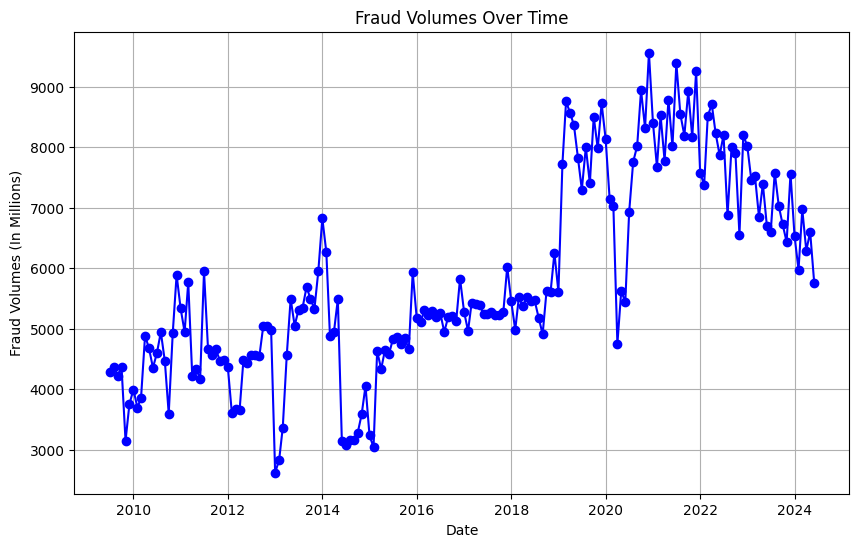

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(fraud_series, marker='o', linestyle='-', color='b')
plt.title('Fraud Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.grid(True)
plt.show()

**Rolling Mean**

- Showing original fraud volumes alongside the rolling mean (moving average) - for smoothing out short-term fluctuations and highliting long-term trends

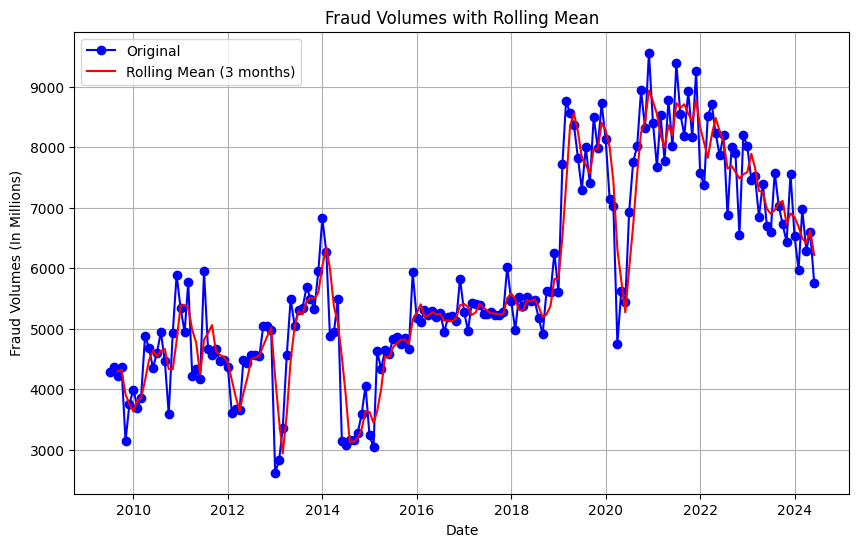

In [48]:
# Calculate the rolling mean with a window of 3 periods
rolling_mean = fraud_series.rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(fraud_series, marker='o', linestyle='-', color='b', label='Original')
plt.plot(rolling_mean, color='r', label='Rolling Mean (3 months)')
plt.title('Fraud Volumes with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Fraud Volumes (In Millions)')
plt.legend()
plt.grid(True)
plt.show()


- Plot of rolling mean and variance can visually indicate whether a series is stationary. 

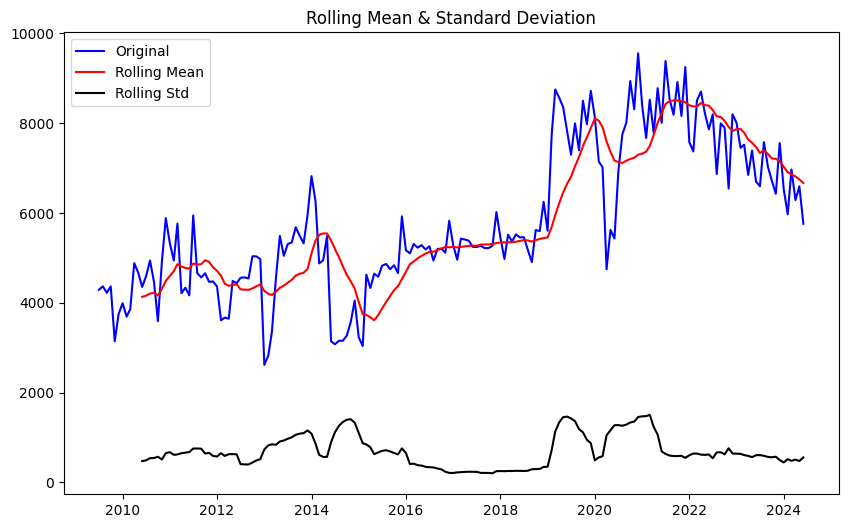

In [56]:
rolling_mean = fraud_series.rolling(window=12).mean()
rolling_std = fraud_series.rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(fraud_series, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

**Seasonal Decomposition Plot**

- Showing the correlation between fraud volume and its own lagged values - for identifying seasonality and the persistence of trends.

- Seasonality is the patterns or fluctuations in the volume of fraud over time. 
- We say seasonality when these patterns are tied to specific periods such as months or years.
- For example, the graphs below shows seasonality in the fraud volumes. 

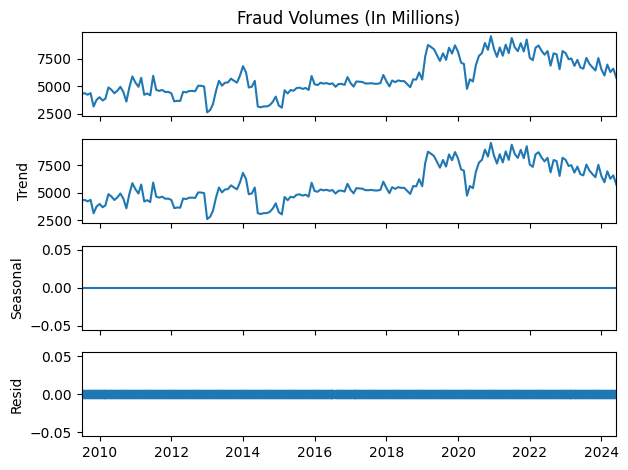

In [50]:
# Decompose the time series using an additive model
decomposition = seasonal_decompose(fraud_series, model='additive', period=1)
decomposition.plot()
plt.show()


**Diagnostic Tests: Stationarity**

- A series with seasonality is not often stationary since the patterns induce regualr fluctuations in the mean (and possibly variance).
- Since fraud volume displays seasonality, it is in order to conduct a formal test to confirm stationarity before modelling. 

In [60]:
adf_result = adfuller(fraud_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -1.2238678992141985
p-value: 0.6632450057782564
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


**Null Hypothesis** - The series has a unit root or not-stationary. 

**ADF Statistic Vs Critical Values**
- The ADF statistic is greater than the critcal values ar 1%, 5%, and 10% significance levels.
- The ADF statitic does not fall within the rejection region.


**p-Value**
- The p-value is also higher than all the three levels of significance.
- Therefore, we fail to reject the null hypothessis. 

**Conclusion** - Not eneough evidence to conclude that the volume of fraud is stationary. The series is likely to have a unit root, and may be stationary. 

**Non-stationarity to stationarity**

**Method 1: Logarithmic Transformation**

In [66]:
log_frauds = np.log(fraud_series)
log_frauds

Date
2009-07-01    8.363711
2009-08-01    8.381548
2009-09-01    8.348296
2009-10-01    8.381641
2009-11-01    8.052962
                ...   
2024-02-01    8.694825
2024-03-01    8.849146
2024-04-01    8.746602
2024-05-01    8.794074
2024-06-01    8.658793
Name: Fraud Volumes (In Millions), Length: 180, dtype: float64

**ADF Test**

In [67]:
adf_result = adfuller(log_frauds)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -1.2786007358807037
p-value: 0.6389047598311984
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


- From the ADF test, **logarithmic transformation does not make the series stationary**. 

**Method 2: Differencing**

In [70]:
fraud_diff = fraud_series.diff().dropna()

In [71]:
adf_result = adfuller(fraud_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.1523815654561425
p-value: 1.0989105479053515e-05
Critical Values:
   1%, -3.470616369591229
Critical Values:
   5%, -2.8792214018977655
Critical Values:
   10%, -2.57619681359045


- 